In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab.patches import cv2_imshow

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve, auc, plot_roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
PATH = "drive/My Drive/MURA-v1.1/"

In [ ]:
train_imgs_path=pd.read_csv(PATH+'train_image_paths_forearm.csv', header=None)
train_labels=pd.read_csv(PATH+'train_labeled_studies_forearm.csv', header=None)
test_imgs_path=pd.read_csv(PATH+'valid_image_paths_forearm.csv', header=None)
test_labels=pd.read_csv(PATH+'valid_labeled_studies_forearm.csv', header=None)

Reading Training and Testing Data

In [ ]:
X_train = np.zeros((len(train_imgs_path),224,224))

for counter,i in enumerate(train_imgs_path.iloc[:,0]):
  img=cv2.imread("drive/My Drive/"+i, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (224, 224))
  kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
  sharpened = cv2.filter2D(img, -1, kernel_sharpening)
  X_train[counter] = sharpened

In [ ]:
X_test = np.zeros((len(test_imgs_path),224,224))

for counter,i in enumerate(test_imgs_path.iloc[:,0]):
  img=cv2.imread("drive/My Drive/"+i, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (224, 224))
  kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
  sharpened = cv2.filter2D(img, -1, kernel_sharpening)
  X_test[counter] = sharpened

In [ ]:
y_train = np.zeros((X_train.shape[0]))
for count,i in enumerate(train_imgs_path.iloc[:,0]):
  x = str(i.split('/')[4])[7:]
  if x == 'positive':
    y_train[count] = 1
  else:
    y_train[count] = 0

In [ ]:
y_test = np.zeros((X_test.shape[0]))
for count,i in enumerate(test_imgs_path.iloc[:,0]):
  x = str(i.split('/')[4])[7:]
  if x == 'positive':
    y_test[count] = 1
  else:
    y_test[count] = 0

**PRE-PROCESSING**

---



In [ ]:
# Reshape the training and test examples
train_set_x_flatten = X_train.reshape(X_train.shape[0], -1).T
test_set_x_flatten = X_test.reshape(X_test.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(y_test.shape))

train_set_x_flatten shape: (50176, 1825)
train_set_y shape: (1825,)
test_set_x_flatten shape: (50176, 301)
test_set_y shape: (301,)


In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [ ]:
train_set_y = y_train.T
test_set_y = y_test.T

Understanding Data Set

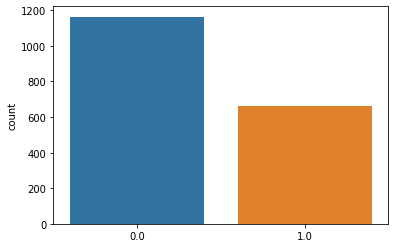

In [ ]:
sns.countplot(y_train)

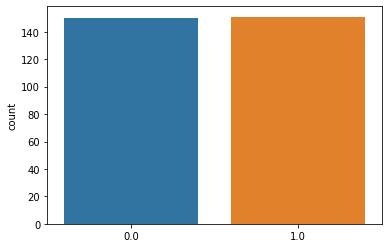

In [ ]:
sns.countplot(y_test)

In [ ]:
train_imgs_path['Image']=train_imgs_path[0].apply(lambda x: str(x.split('/')[5])[5:6])
test_imgs_path['Image']=test_imgs_path[0].apply(lambda x: str(x.split('/')[5])[5:6])
train_imgs_path['Study']=train_imgs_path[0].apply(lambda x: str(x.split('/')[4])[0:6])
test_imgs_path['Study']=test_imgs_path[0].apply(lambda x: str(x.split('/')[4])[0:6])

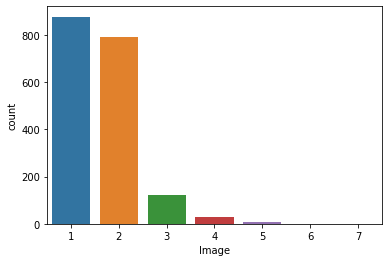

In [ ]:
sns.countplot(train_imgs_path[:]['Image'])

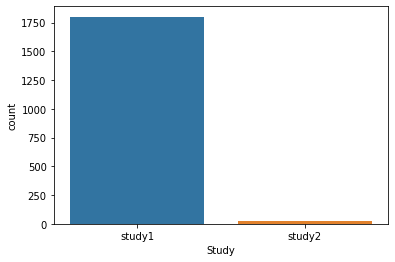

In [ ]:
sns.countplot(train_imgs_path[:]['Study'])

**Logistic Regression**

In [ ]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [ ]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [ ]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    dw = (1 / m) * np.dot(X , (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b , X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
def predict(w, b, X):    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.003, print_cost = False):
    """
    Input:
    X_train -- training data
    Y_train -- training labels 
    X_test -- test data
    Y_test -- test labels
    num_iterations -- number of iterations to optimize the parameters
    learning_rate -- learning rate used in the update rule of optimize function
    print_cost -- to print the cost every 100 iterations
    
    Output:
    d -- dictionary containing information about the model.
    """
    
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    train_accuracy = 100 - (np.mean(np.abs(Y_prediction_train - Y_train)) * 100)
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

    # Print train/test Errors
    print("train accuracy: {} %".format(train_accuracy))
    print("test accuracy: {} %".format(test_accuracy))
    

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "train_accuracy": train_accuracy,
         "test_accuracy": test_accuracy}
    
    return d

In [ ]:
d = model(train_set_x, y_train, test_set_x, y_test, num_iterations = 2000, learning_rate =0.03)

In [ ]:
print("Confusion Matrix")
cm_lr = confusion_matrix(y_test, d['Y_prediction_test'].T)
print(cm_lr)

Confusion Matrix
[[115  35]
 [100  51]]


In [ ]:
p_lr = precision_score(y_test, d['Y_prediction_test'].T)
print("Precision is", p_lr)

Precision is 0.5930232558139535


In [ ]:
r_lr = recall_score(y_test, d['Y_prediction_test'].T)
print("Recall is", r_lr)

Recall is 0.33774834437086093


In [ ]:
f1_lr = f1_score(y_test, d['Y_prediction_test'].T)
print("F1 score is", f1_lr)

F1 score is 0.430379746835443


In [ ]:
print("True Postitive Rate(TPR)", cm_lr[0][0] / (cm_lr[0][0] + cm_lr[1][0]))
print("False Positive Rate(FPR)", cm_lr[0][1] / (cm_lr[0][1] + cm_lr[1][1]))

True Postitive Rate(TPR) 0.5348837209302325
False Positive Rate(FPR) 0.4069767441860465


SkLearn Preprocessing

In [ ]:
# Preprocessing for sk-learn

X_train = train_set_x.T
X_test = test_set_x.T

**SVM**

In [ ]:
# C = [0.1, 1, 10, 100]
clf = SVC(C=100, kernel='rbf', gamma='auto', random_state=False)

clf.fit(X_train, y_train)

y_pred_train_svm = clf.predict(X_train)
y_pred_test_svm = clf.predict(X_test)

In [ ]:
print("Training Accuracy:",metrics.accuracy_score(y_train, y_pred_train_svm))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_svm))

Training Accuracy: 0.9912328767123287
Testing Accuracy: 0.574750830564784


In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_test_svm)
print("Confusion Matrix")
print(cm_svm)

Confusion Matrix
[[124  26]
 [102  49]]


In [ ]:
p_svm = precision_score(y_test, y_pred_test_svm)
print("Precision is", p_svm)

Precision is 0.6533333333333333


In [ ]:
r_svm = recall_score(y_test, y_pred_test_svm)
print("Recall is", r_svm)

Recall is 0.32450331125827814


In [ ]:
f1_svm = f1_score(y_test, y_pred_test_svm)
print("F1 score is", f1_svm)

F1 score is 0.4336283185840708


In [ ]:
print("True Postitive Rate(TPR)", cm_svm[0][0] / (cm_svm[0][0] + cm_svm[1][0]))
print("False Positive Rate(FPR)", cm_svm[0][1] / (cm_svm[0][1] + cm_svm[1][1]))

True Postitive Rate(TPR) 0.5486725663716814
False Positive Rate(FPR) 0.3466666666666667


AUC ROC Curve


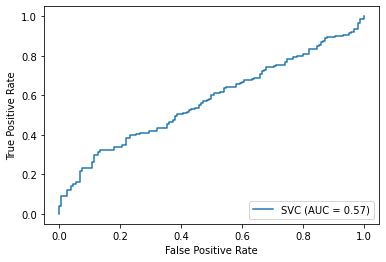

In [ ]:
print("AUC ROC Curve")
svc_disp = plot_roc_curve(clf, X_test, y_test)
plt.show()

**Bagging**

In [ ]:
bagging_clf = BaggingClassifier(base_estimator=SVC(C=100.0, kernel='rbf', gamma='auto', random_state=False), 
                        n_estimators=10, random_state=False)

bagging_clf.fit(X_train, y_train)

y_pred_train_bagging = bagging_clf.predict(X_train)
y_pred_test_bagging = bagging_clf.predict(X_test)

In [ ]:
print("Training Accuracy:",metrics.accuracy_score(y_train, y_pred_train_bagging))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_bagging))

Training Accuracy: 0.943013698630137
Testing Accuracy: 0.5614617940199336


In [ ]:
cm_bagging = confusion_matrix(y_test, y_pred_test_bagging)
print("Confusion Matrix")
print(cm_bagging)

Confusion Matrix
[[125  25]
 [107  44]]


In [ ]:
p_bagging = precision_score(y_test, y_pred_test_bagging)
print("Precision is", p_bagging)

Precision is 0.6376811594202898


In [ ]:
r_bagging = recall_score(y_test, y_pred_test_bagging)
print("Recall is", r_bagging)

Recall is 0.2913907284768212


In [ ]:
f1_bagging = f1_score(y_test, y_pred_test_bagging)
print("F1 score is", f1_bagging)

F1 score is 0.39999999999999997


In [ ]:
print("True Postitive Rate(TPR)", cm_bagging[0][0] / (cm_bagging[0][0] + cm_bagging[1][0]))
print("False Positive Rate(FPR)", cm_bagging[0][1] / (cm_bagging[0][1] + cm_bagging[1][1]))

True Postitive Rate(TPR) 0.5387931034482759
False Positive Rate(FPR) 0.36231884057971014


AUC ROC Curve


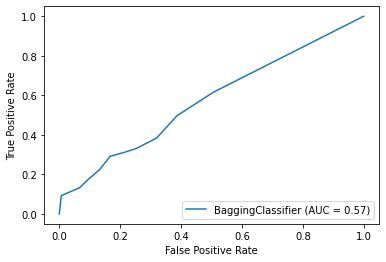

In [ ]:
print("AUC ROC Curve")
svc_disp = plot_roc_curve(bagging_clf, X_test, y_test)
plt.show()

*Gradient Boosting*

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=30, subsample=1.0, 
                                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, random_state=None, 
                                            max_features=None, max_leaf_nodes=None)

gbc.fit(X_train, y_train)

y_pred_test_gbc = gbc.predict(X_test)
y_pred_train_gbc = gbc.predict(X_train)

Validation Accuracy: 0.8131506849315069
Validation Accuracy: 0.5681063122923588


In [ ]:
print("Training Accuracy:",metrics.accuracy_score(y_train, y_pred_train_gbc))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_test_gbc))

Validation Accuracy: 0.8131506849315069
Validation Accuracy: 0.5681063122923588


In [ ]:
cm_gbc = confusion_matrix(y_test, y_pred_test_gbc)
print("Confusion Matrix")
print(cm_gbc)

Confusion Matrix
[[134  16]
 [114  37]]


In [ ]:
p_gbc = precision_score(y_test, y_pred_test_gbc)
print("Precision is", p_gbc)

Precision is 0.6981132075471698


In [ ]:
r_gbc = recall_score(y_test, y_pred_test_gbc)
print("Recall is", r_gbc)

Recall is 0.24503311258278146


In [ ]:
f1_gbc = f1_score(y_test, y_pred_test_gbc)
print("F1 score is", f1_gbc)

F1 score is 0.3627450980392157


In [ ]:
print("True Postitive Rate(TPR)", cm_gbc[0][0] / (cm_gbc[0][0] + cm_gbc[1][0]))
print("False Positive Rate(FPR)", cm_gbc[0][1] / (cm_gbc[0][1] + cm_gbc[1][1]))

True Postitive Rate(TPR) 0.5403225806451613
False Positive Rate(FPR) 0.3018867924528302


In [ ]:
print("AUC ROC Curve")
svc_disp = plot_roc_curve(gbc, X_test, y_test)
plt.show()

**CNN**

In [ ]:
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization
from keras.layers import Flatten, Activation

In [ ]:
x_train = X_train.reshape(-1,224,224,1)
x_test = X_test.reshape(-1,224,224,1)
y_train = train_set_y
y_test = test_set_y

In [ ]:
print("Pre processing data")
X_train = x_train / 255.0
X_test = x_test / 255.0

Pre processing data


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 90,
    # shear_range = 0.2,
    # zoom_range = 0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip = True
)
train_datagen.fit(X_train)

# Declaring batch of data
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 64
)

In [ ]:
# Number of steps to be run
steps = int(X_train.shape[0]/64)

In [ ]:
# define the training model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = 'elu', input_shape = (224, 224, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides = 1, padding = "same", activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "elu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "elu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization_43 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_44 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 112, 112, 64)     

In [ ]:
print("Training")
model.compile( optimizer='nadam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(train_generator, steps_per_epoch = steps, epochs = 100, validation_data = (X_test, y_test))

Training
Epoch 1/100
28/28 [==============================] - 23s 828ms/step - loss: 0.9868 - accuracy: 0.5906 - val_loss: 6.1049 - val_accuracy: 0.5017
Epoch 2/100
28/28 [==============================] - 21s 732ms/step - loss: 0.6443 - accuracy: 0.6684 - val_loss: 1.7216 - val_accuracy: 0.5017
Epoch 3/100
28/28 [==============================] - 20s 725ms/step - loss: 0.6113 - accuracy: 0.6928 - val_loss: 1.4637 - val_accuracy: 0.4983
Epoch 4/100
28/28 [==============================] - 20s 726ms/step - loss: 0.6179 - accuracy: 0.6854 - val_loss: 0.7155 - val_accuracy: 0.4983
Epoch 5/100
28/28 [==============================] - 20s 730ms/step - loss: 0.6076 - accuracy: 0.6905 - val_loss: 1.1206 - val_accuracy: 0.4983
Epoch 6/100
28/28 [==============================] - 20s 731ms/step - loss: 0.5848 - accuracy: 0.7047 - val_loss: 1.4827 - val_accuracy: 0.4983
Epoch 7/100
28/28 [==============================] - 20s 729ms/step - loss: 0.5696 - accuracy: 0.7223 - val_loss: 0.9025 - val_

In [ ]:
print("evaluate")
model.evaluate(X_test, y_test) 

evaluate
301/301 [==============================] - 1s 3ms/step


[1.8188337257930212, 0.5382059812545776]

In [ ]:
y_pred_train_cnn = model.predict_classes(X_train)
y_pred_test_cnn = model.predict_classes(X_test)

In [ ]:
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_cnn))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_cnn))

Training Accuracy: 0.5408219178082192
Testing Accuracy: 0.5382059800664452


In [ ]:
cm_cnn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm_cnn)

Confusion Matrix
[[128  22]
 [113  38]]


In [ ]:
p_cnn = precision_score(y_test, y_pred_test_cnn)
print("Precision is", p_cnn)

Precision is 0.538961038961039


In [ ]:
r_cnn = recall_score(y_test, y_pred_test_cnn)
print("Recall is", r_cnn)

Recall is 0.5496688741721855


In [ ]:
f1_cnn = f1_score(y_test, y_pred_test_cnn)
print("F1 score is", f1_cnn)

F1 score is 0.5442622950819672


In [ ]:
print("True Positive Rate(TPR)", cm_cnn[0][0] / (cm_cnn[0][0] + cm_cnn[1][0]))
print("False Positive Rate(FPR)", cm_cnn[0][1] / (cm_cnn[0][1] + cm_cnn[1][1]))

True Postitive Rate(TPR) 0.5311203319502075
False Positive Rate(FPR) 0.36666666666666664
